
Data from Stanford EgoNets - Facebook circles:
https://snap.stanford.edu/data/egonets-Facebook.html
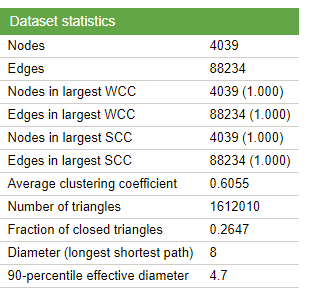

Facebook Network Analysis and Link Prediction using Binary Classifier


The exploratory work is organized as follows:
1. Load Facebook Network
2. Visualize the Network and perform Network Analysis
3. Identifying Central Nodes, plot them and perform closeness and degree measures
4. Creating a negative edge subset and random sampling 
5. Creating a Train/Test Dataset based on positive and negative edges
6. Feature Extraction of important Link Prediction Methods : Jaccard, Preferential Attachment, Adam Adar ,etc
7. Binary Classsification for prediting Links using Random Forest and XGB
8. Tuning,Accuracy Metrics and ROC curves 

In [308]:
import pandas as pd
from textblob import TextBlob
import nltk
import string
import random
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import operator
import community

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#Model Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc , roc_auc_score

#Train Test data prepration and parameter tuning 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [3]:
#Load the facebook ego data to a dataframe
df= pd.read_csv("facebook_combined.txt",sep=" ", header=None)

In [5]:
df.columns = ['node','neighbor']

In [6]:
df.head()

,node,neighbor
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [7]:
# Create a network graph from the dataframe
g = nx.Graph()
g = nx.from_pandas_dataframe(df,source='node',target = 'neighbor')

In [12]:
# This is a good size network with 4039 nodes and 88234 edges.
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


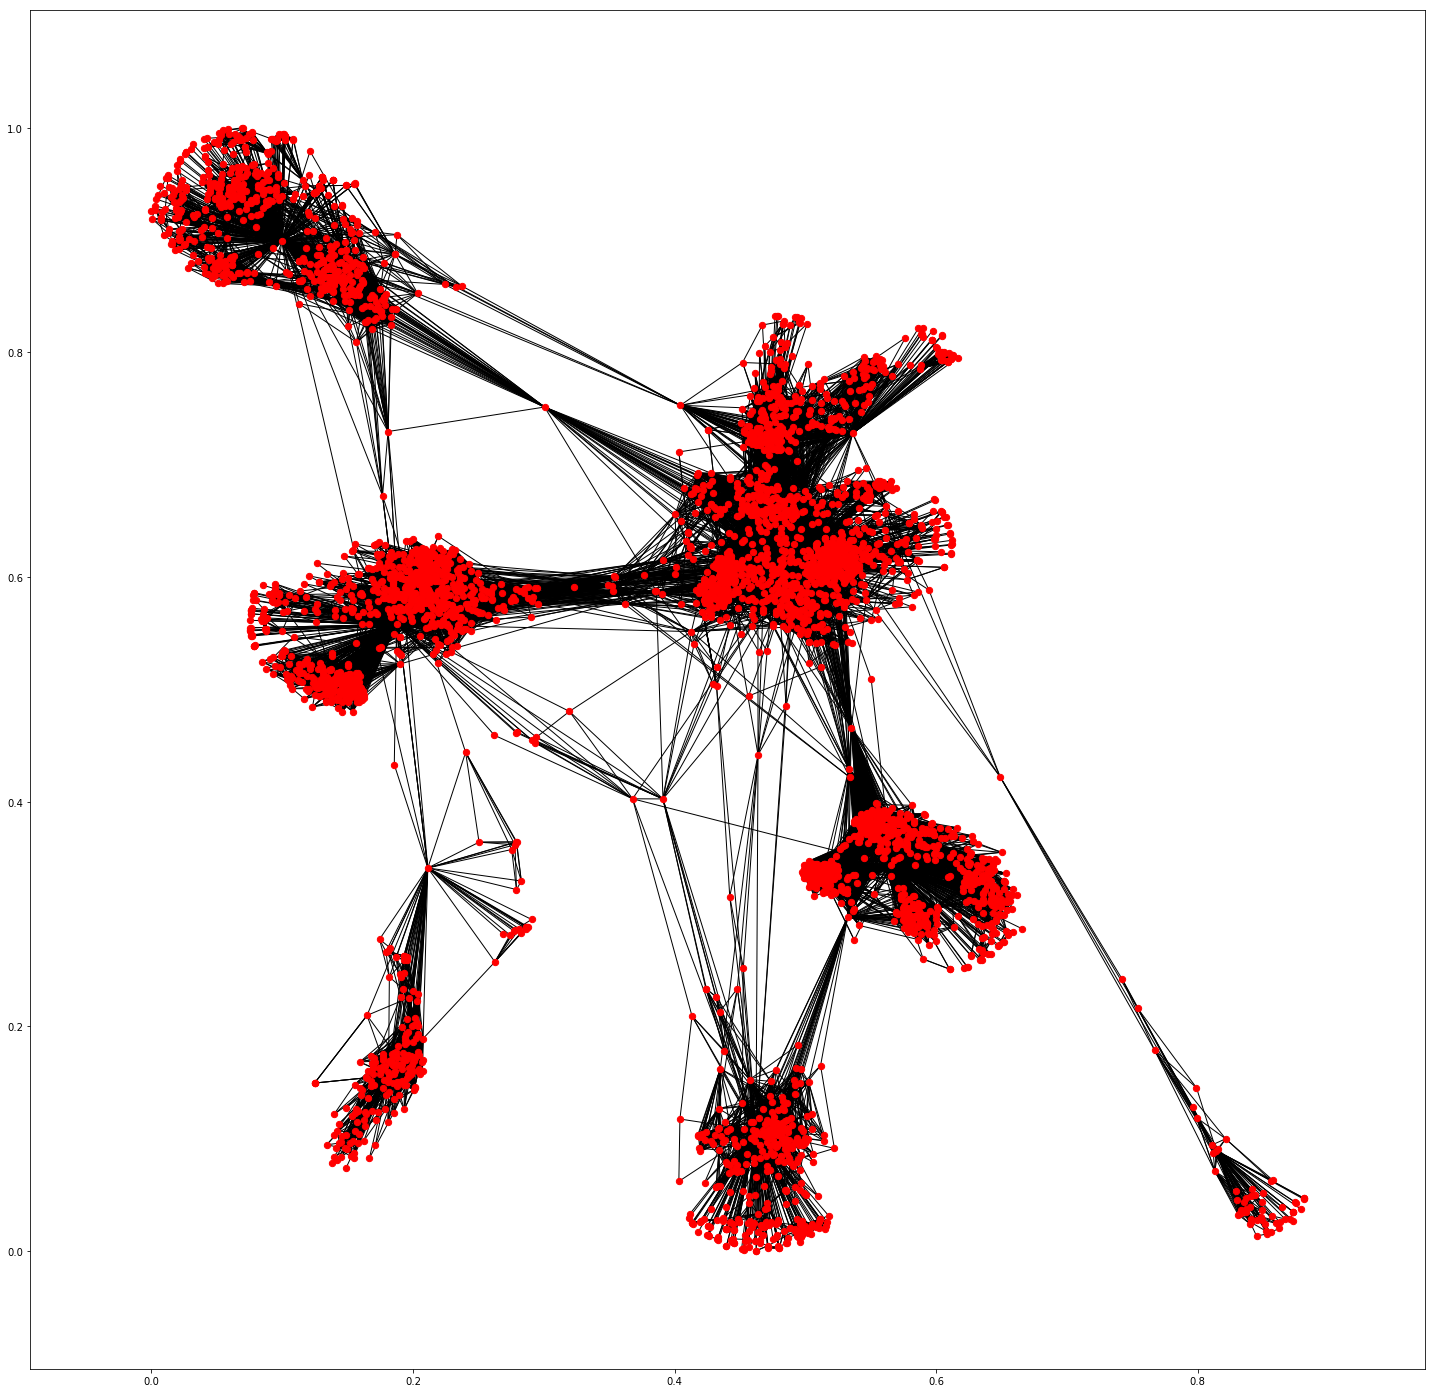

In [26]:
# In the plot below we can see sevaral hubs and influnetial nodes connecting those hubs
plt.figure(figsize = (25,25))
nx.draw_networkx(g,with_labels=False,node_size=40)
plt.show()

In [13]:
# Lets get the top 10 central nodes in the network
centrality = pd.DataFrame(nx.degree_centrality(g),index = [0])
centrality= centrality.T.reset_index()
centrality.columns.values[0]= "character"
centrality.columns.values[1]= "degreec"
centrality.sort_values(by = 'degreec',ascending = False).head(10)

,character,degreec
107,107,0.258791
1684,1684,0.196137
1912,1912,0.186974
3437,3437,0.135463
0,0,0.085934
2543,2543,0.072808
2347,2347,0.072065
1888,1888,0.062902
1800,1800,0.060674
1663,1663,0.058197


In [14]:
# Find other Centrality measure like Closeness, Betweenness, Eigen Vectors centrality
print("Closeness Centrality:\n",sorted(nx.closeness_centrality(g).items(), key=operator.itemgetter(1),reverse=True)[0:10])
print("\nBetweenness Centrality:\n",sorted(nx.betweenness_centrality(g).items(), key=operator.itemgetter(1),reverse=True)[0:10])
print("\nEigenVector Centrality:",sorted(nx.eigenvector_centrality(g).items(), key=operator.itemgetter(1),reverse=True)[0:10])

Closeness Centrality:
 [(107, 0.45969945355191255), (58, 0.3974018305284913), (428, 0.3948371956585509), (563, 0.3939127889961955), (1684, 0.39360561458231796), (171, 0.37049270575282134), (348, 0.36991572004397216), (483, 0.3698479575013739), (414, 0.3695433330282786), (376, 0.36655773420479304)]

Betweenness Centrality:
 [(107, 0.4805180785560152), (1684, 0.3377974497301992), (3437, 0.23611535735892905), (1912, 0.2292953395868782), (1085, 0.14901509211665306), (0, 0.14630592147442917), (698, 0.11533045020560802), (567, 0.09631033121856215), (58, 0.08436020590796486), (428, 0.06430906239323866)]

EigenVector Centrality: [(1912, 0.09540688873596534), (2266, 0.0869832822632196), (2206, 0.08605240174265634), (2233, 0.08517341350597848), (2464, 0.08427878364685958), (2142, 0.08419312450068113), (2218, 0.08415574433673872), (2078, 0.08413617905810125), (2123, 0.08367142125897371), (1993, 0.08353243711860489)]


In [15]:
#get the degrees of each node and print the first 10 highest nodes
degree = nx.degree(g)

In [16]:
print(sorted(degree.items(), key=operator.itemgetter(1),reverse=True)[0:10])

[(107, 1045), (1684, 792), (1912, 755), (3437, 547), (0, 347), (2543, 294), (2347, 291), (1888, 254), (1800, 245), (1663, 235)]


In [22]:
# Other network properties like connected subgraphs. Here we see a value of 1
components = nx.connected_component_subgraphs(g)
print(len(list(components)))
components

1


<generator object connected_component_subgraphs at 0x000001CD287361A8>

In [21]:
nx.number_connected_components(g)

1

In [107]:
#Lets get the top 10 nodes with highest degree and only plot those nodes
degree_c = sorted(nx.degree_centrality(g).items(), key=operator.itemgetter(1),reverse=True)[0:20]

In [108]:
#fecth the nodes and their degree
high_degree_nodes = [i[0] for i in degree_c]
high_degree_size = [i[0] for i in degree_c]

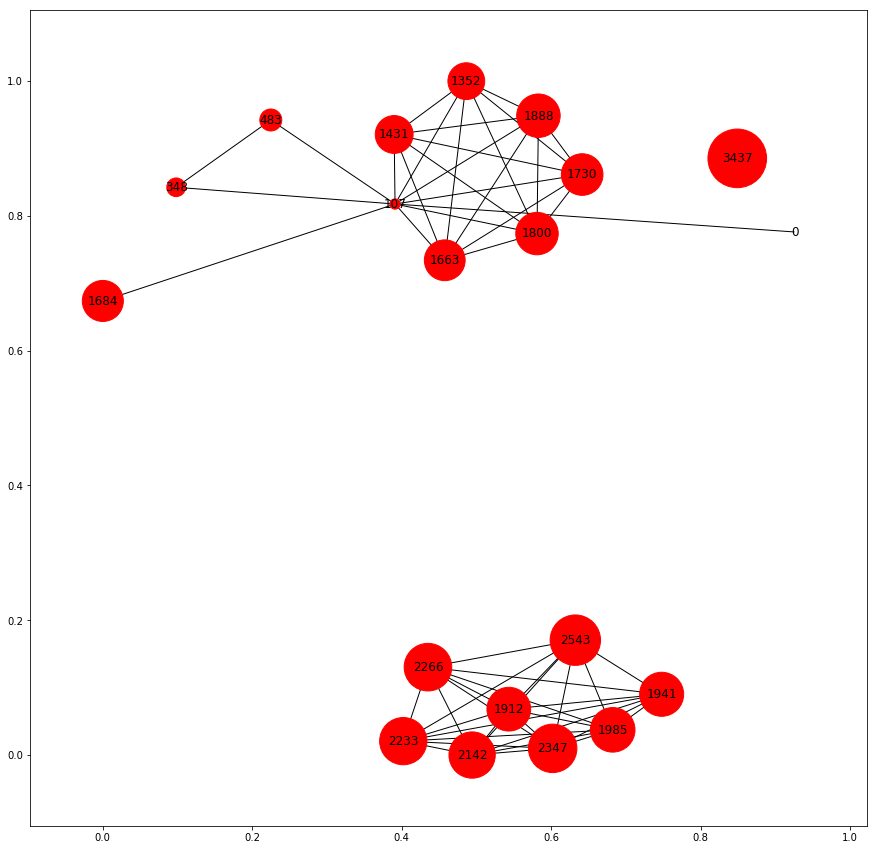

In [113]:
#Network of highest degree nodes
#Bubble size reflects the degreee. We cann see that most of the high degree nodes are connected and have different subgraphs
plt.figure(figsize = (15,15))
high_degree_graph = g.subgraph(high_degree_nodes)
nx.draw_networkx(high_degree_graph, node_size = high_degree_size * 1000 )
plt.show()

In [50]:
# Show the central nodes
nodes = [5]*len(g.nodes())
colors = [0]*len(g.nodes())
for i, val in degree_c:
    nodes[i] = 150
    colors[i] = 2

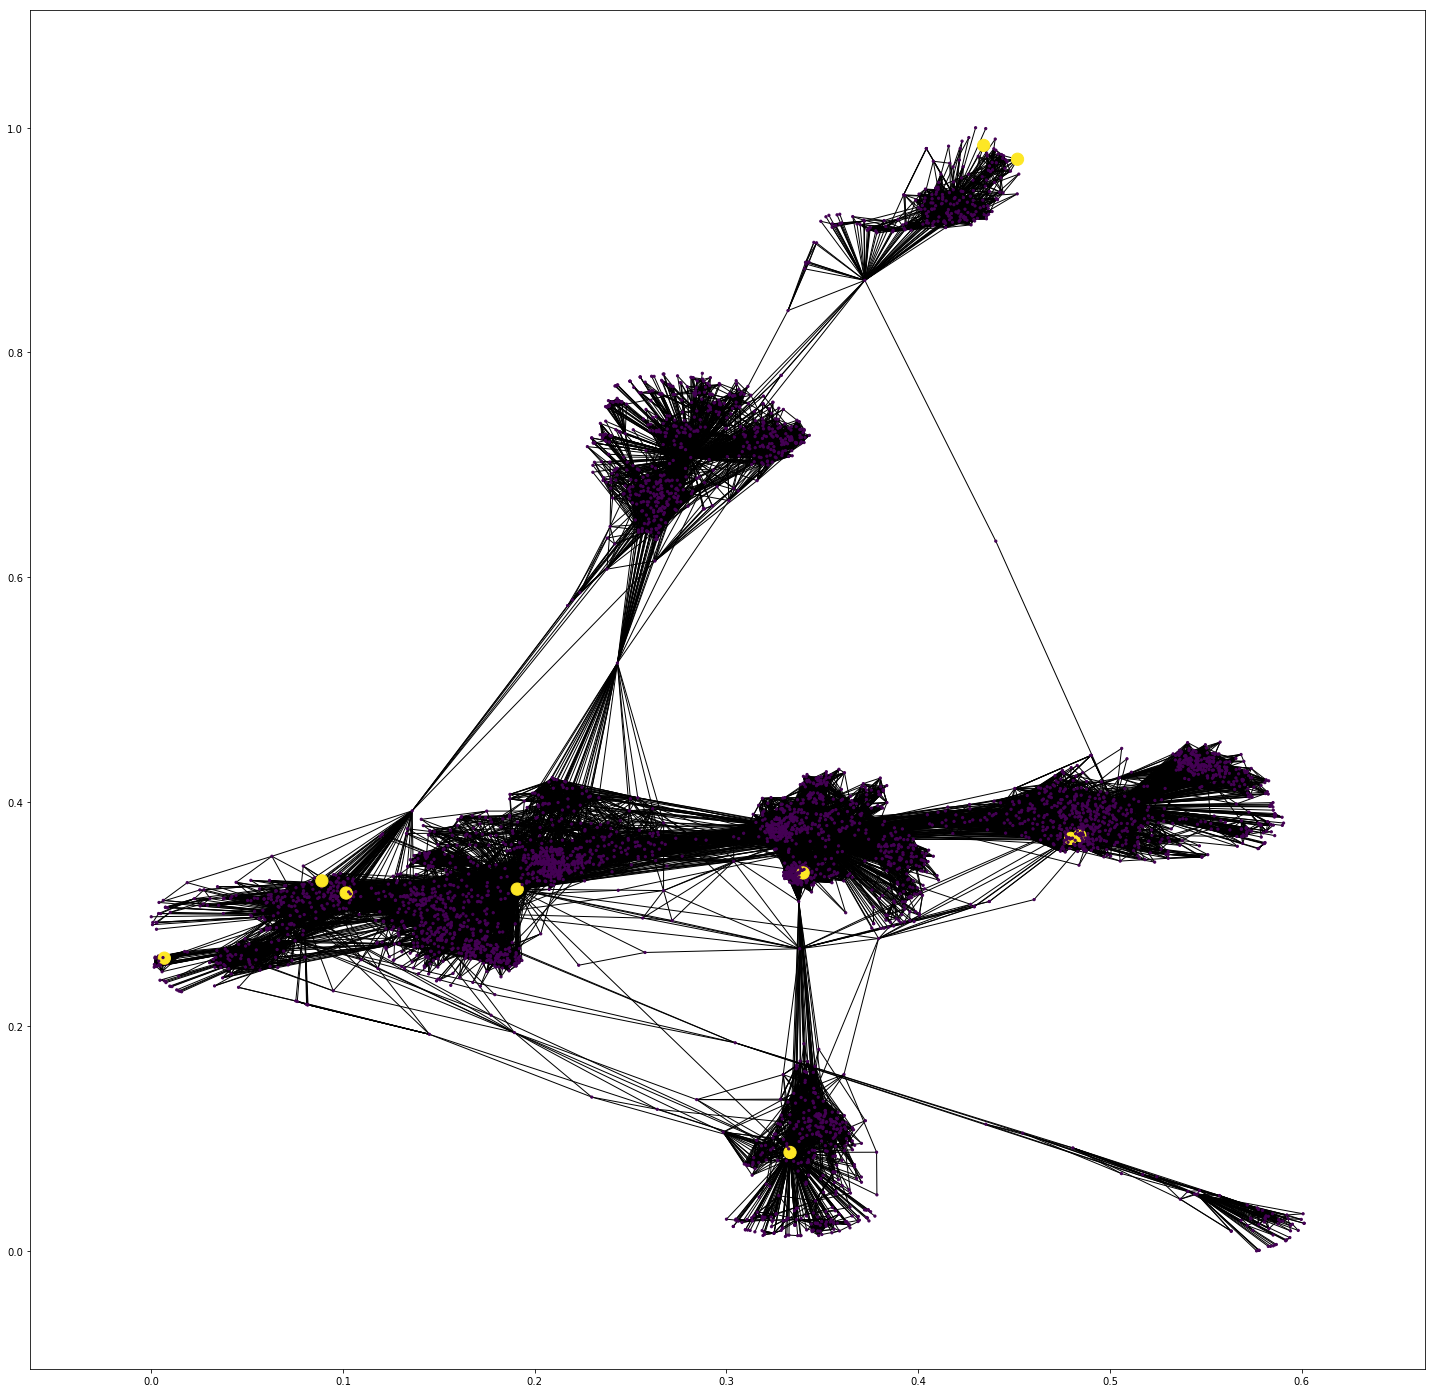

In [52]:
# The graph shows the top 10 central nodes in the network based on degree centrality
plt.figure(figsize = (25,25))
nx.draw_networkx(g,with_labels=False,node_color = colors, node_size=nodes)
plt.show()

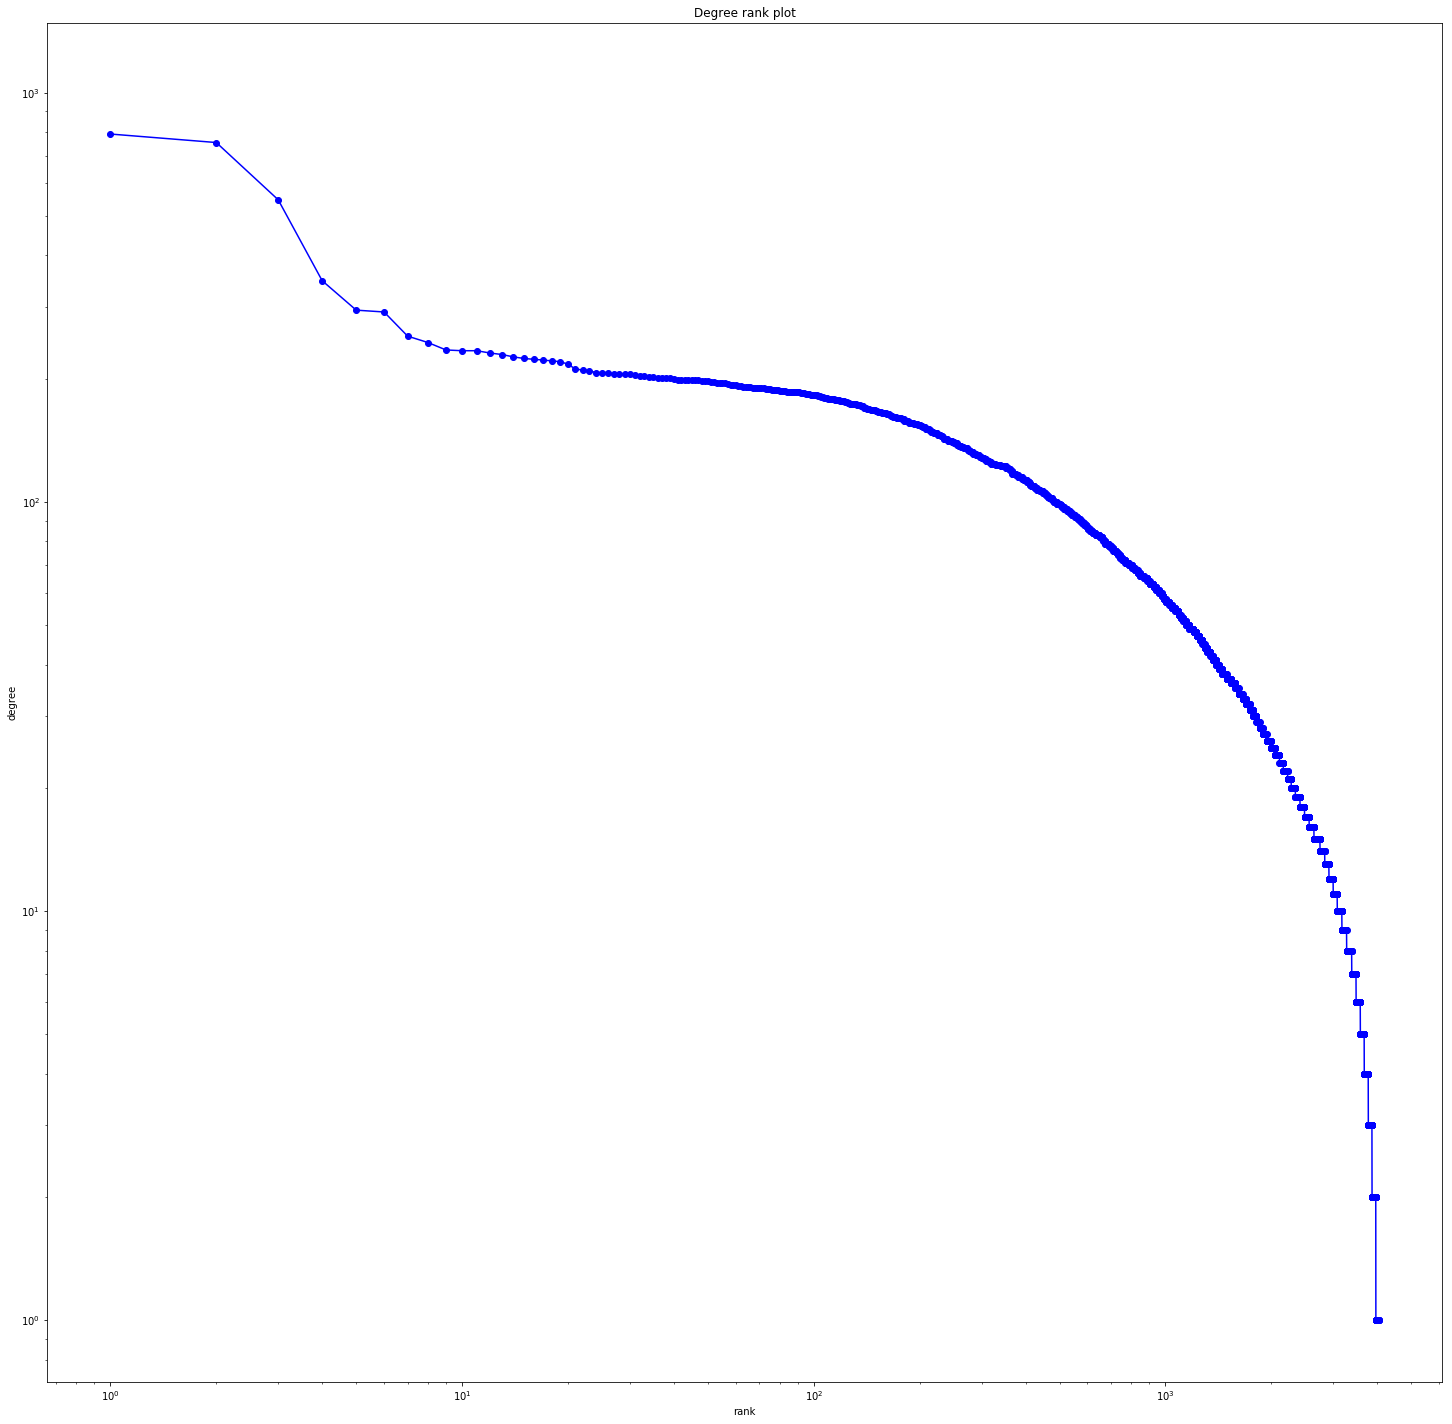

In [60]:
# Show Degree Plot. This shows a power law property of the network.
degree_sequence=sorted(nx.degree(g).values(),reverse=True)
# degree sequence
#print("Degree sequence", degree_sequence)
dmax=max(degree_sequence)
plt.figure(figsize = (25,25))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

We will next create link prediction for our network by combining positive edges and a random sample of negative edges , sane size as positive edges

In [160]:
# Find non edge nodes
non_edges = list(nx.non_edges(g))

In [165]:
print(non_edges[:10])

[(0, 348), (0, 349), (0, 350), (0, 351), (0, 352), (0, 353), (0, 354), (0, 355), (0, 356), (0, 357)]


In [161]:
# As expected the number of negative edges are quite high
print(len(non_edges))

8066507


In [188]:
#create a dataframe of positive edges with label as 1
df_edges = pd.DataFrame(g.edges())
df_edges.columns = ['nodefr','nodeto']
df_edges['label'] = 1
df_edges.head()

,nodefr,nodeto,label
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1


In [189]:
# Get a random sample of negative edges equal to size of positive edges
# label them as 0
df_random_neg_edges = pd.DataFrame(random.sample(non_edges, len(edges)))
df_random_neg_edges.columns = ['nodefr','nodeto']
df_random_neg_edges['label'] = 0
df_random_neg_edges.head()

,nodefr,nodeto,label
0,2356,2367,0
1,809,2385,0
2,1023,1093,0
3,170,2136,0
4,2046,3663,0


In [192]:
#create an edge set by combining negatibe and positive edges
df_pos_neg_edges = df_edges.append(df_random_neg_edges)

In [193]:
print(df_pos_neg_edges.shape)

(176468, 3)


In [198]:
#create a graph of positive an negative edges
n_g1 = nx.Graph()
n_g1 = nx.from_pandas_dataframe(df_pos_neg_edges,source = 'nodefr', target = 'nodeto' , edge_attr = 'label')

In [203]:
pos_neg_edges = df_pos_neg_edges[['nodefr','nodeto']].values.tolist()

In [206]:
# perform feature selection using Preferential Attachment, Jaccard and Adamic Adar Link predictions
posneg_preferential_attachment  = pd.DataFrame(nx.preferential_attachment(n_g1, ebunch = pos_neg_edges))
posneg_jaccard = pd.DataFrame(nx.jaccard_coefficient(n_g1, ebunch = pos_neg_edges))
posneg_adamic_adar_index = pd.DataFrame(nx.adamic_adar_index(n_g1, ebunch = pos_neg_edges))


In [207]:
posneg_preferential_attachment.columns = ['nodefr','nodeto','prefattach']
posneg_jaccard.columns = ['nodefr','nodeto','jaccard']
posneg_adamic_adar_index.columns = ['nodefr','nodeto','adamar']

In [217]:
# prepare teh dataset to be used for binary classification
merge1 = pd.merge(df_pos_neg_edges, posneg_preferential_attachment,
                       how='left', on=['nodefr', 'nodeto'])
merge2 = pd.merge(merge1, posneg_jaccard,
                       how='left', on=['nodefr', 'nodeto'])
featureset = pd.merge(merge2, posneg_adamic_adar_index,
                       how='left', on=['nodefr', 'nodeto'])

In [262]:
featureset['edges'] = featureset['nodefr'].astype(str) + "-" + featureset['nodeto'].astype(str)
featureset.set_index('edges')
featureset.head()


,nodefr,nodeto,label,prefattach,jaccard,adamar,edges
0,0,1,1,23640,0.043678,4.534947,0-1
1,0,2,1,20094,0.027714,2.900834,0-2
2,0,3,1,20882,0.039535,3.919148,0-3
3,0,4,1,17336,0.025761,2.748795,0-4
4,0,5,1,24428,0.043478,4.515716,0-5


In [235]:
# get the prediction label
output = featureset['label']

In [236]:
output.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [292]:
#get the feature set
feature_imp = featureset[['prefattach','jaccard','adamar']]

In [283]:
#feature_imp = featureset[['prefattach']]

In [293]:
feature_imp.head() 

,prefattach,jaccard,adamar
0,23640,0.043678,4.534947
1,20094,0.027714,2.900834
2,20882,0.039535,3.919148
3,17336,0.025761,2.748795
4,24428,0.043478,4.515716


In [285]:
#First split test and train data set
X_train, X_test, y_train, y_test = train_test_split(feature_imp,output, test_size=.25, random_state=10) 

In [286]:
print (X_train.shape,y_train.shape, X_test.shape,y_test.shape)

(132351, 1) (132351,) (44117, 1) (44117,)


In [287]:
# Run a Random Forest Classsifier
model = RandomForestClassifier(n_estimators = 500, class_weight = 'balanced',oob_score = True, n_jobs = -1,random_state =50)
model.fit(X_train, y_train)
proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test,proba[:, 1])
print("AUC", auc) 


AUC 0.810836823399


In [ ]:
# Run classifier for different combinations of features. We see that combining all features gives highest AUC
#AUC 0.992158745577 for all 3 features
#AUC 0.810836795654 for pref attachment
#AUC 0.986518308934 for jaccard

In [288]:
# Run another Random Forest Classifier  with max depth and min_split samples
model = RandomForestClassifier(class_weight = 'balanced',max_depth = 10, oob_score = True,n_estimators = 500 ,min_samples_split = 2,random_state=82 )
model.fit(X_train, y_train)
proba = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])


In [289]:
print("Acc Score:",accuracy_score(y_test,model.predict(X_test)))
print("F1 Score:", f1_score(y_test,model.predict(X_test)))
auc = roc_auc_score(y_test,proba[:, 1])
print("AUC", auc) 


Acc Score: 0.737040143255
F1 Score: 0.710127183229
AUC 0.81166509568


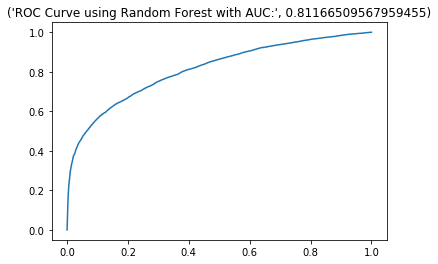

In [300]:
# ROC Curve using Random Forest
plt.plot(fpr,tpr)
title = "ROC Curve using Random Forest with AUC:", auc
plt.title(title)
plt.show()


In [291]:
# Run an XGB model. Results are similar to Random Forest giving a high AUC
model = xgb.XGBClassifier(n_estimators = 500 , learning_rate = 0.01)
model.fit(X_train,y_train, eval_metric='auc')
#estimator.get_params()
y_pred = model.predict(X_test)
#evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.5f%%" % (accuracy * 100.0))
proba = model.predict_proba(X_test)
fprXGB, tprXGB, thresholds = roc_curve(y_test, proba[:, 1])
aucXGB = roc_auc_score(y_test,proba[:, 1])
print("AUC", aucXGB) 

Accuracy: 73.31414%
AUC 0.807715071803


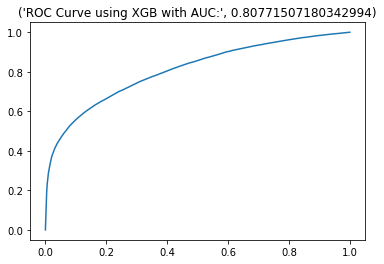

In [298]:
# ROC Curve using XGB
plt.plot(fprXGB,tprXGB)
titleXGB = "ROC Curve using XGB with AUC:", aucXGB
plt.title(titleXGB)
plt.show()

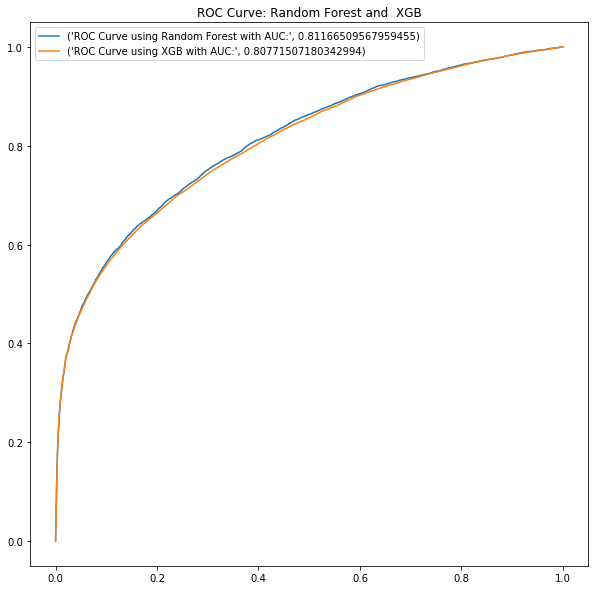

In [307]:
#Plot ROC Curves together
plt.figure(0).clf()
plt.figure(figsize = (10,10))

plt.plot(fpr,tpr,label= title)
plt.plot(fprXGB,tprXGB,label = titleXGB)
plt.legend(loc=0)
plt.title("ROC Curve: Random Forest and  XGB")
plt.show()